In [3]:
mypackagepath = "/home/jovyan/work/workspace/rlib"
.libPaths(c(mypackagepath,.libPaths()))
load_libs <- function(packages) {
    for(package in packages) {
        test <- require(package, character.only=TRUE)
        if(!test) {
            install.packages(package)
            library(package)
        }
    }
}
load_libs(c("doParallel", "foreach", "ncdf4", "SPEI"))

## Define function to compute the drought index (following SPI methodology)

*array* is an array of the variable of interest with a global extent, *months* is the time period SPI is counted for, *resolution* is the resolution of the global array, *filename* specifies the filename of the output netcdf, and *ncores* is the number of cores used for parallelization.

In [11]:
# requires a global array
compute_index <- function(array, months, resolution, filename, ncores) {
    dims <- dim(array)
    message("calculating index..")
    registerDoParallel(ncores)
    di <- foreach(lon = 1:dims[1]) %dopar% {
        output <- foreach(lat = 1:dims[2]) %do% {
            if(!sea[lon,lat]){
                data <- runoff[lon,lat,]
                data <- data[!is.na(data)] 
                if(length(data) > months ) {
                    spi <- spi(data, scale = months, distribution = 'Gamma')
                    ret <- spi$fitted
                } else {
                    ret <- rep(-9999, dims[3])
                }
            } else {
                ret <- NA
            }
            return(ret)
        } 
        output
    }
    stopImplicitCluster()
    message("creating array...")
    
    # create array
    diarr <- array(NA, dim=dims)
    
    for(i in seq_along(di)) {
        for(j in seq_along(di[[i]])) {
            test <- length(di[[i]][[j]]) == dims[3]
            if(test) diarr[i,j,] <- di[[i]][[j]]
        }
    }     
    
    # write array to nc
    message("writing netcdf...")
    halfres <- resolution/2
    xvals <- seq(-180+halfres, 180-halfres, resolution)
    yvals <- seq(-90+halfres, 90-halfres, resolution) 
    nx <- length(xvals)
    ny <- length(yvals)
    lon1 <- ncdim_def("longitude", "degrees_east", xvals)
    lat2 <- ncdim_def("latitude", "degrees_north", yvals)
    
    time <- ncdim_def("Time","months", dims[3], unlim=TRUE)
    mv <- -9999 #missing value to use
    var_temp <- ncvar_def("var", "m3/s", 
                          list(lon1, lat2, time), 
                          longname=filename, 
                          mv) 
    nc <- nc_create(filename, list(var_temp))
    ncvar_put(nc, var_temp, diarr, start=c(1,1,1), count=c(nx,ny,dims[3]))
    nc_close(nc)
}

## Compute SRI and SSI

In [5]:
# read in array
nc <- nc_open( "./runoff_global_monthly.nc"))
runoff <- ncvar_get(nc, attributes(nc$var)$names[1])
nc_close(nc)

Make a mask to speed up computation (we dont need to process cells which have 0's for all timesteps).

   user  system elapsed 
  4.812   0.420   5.230 

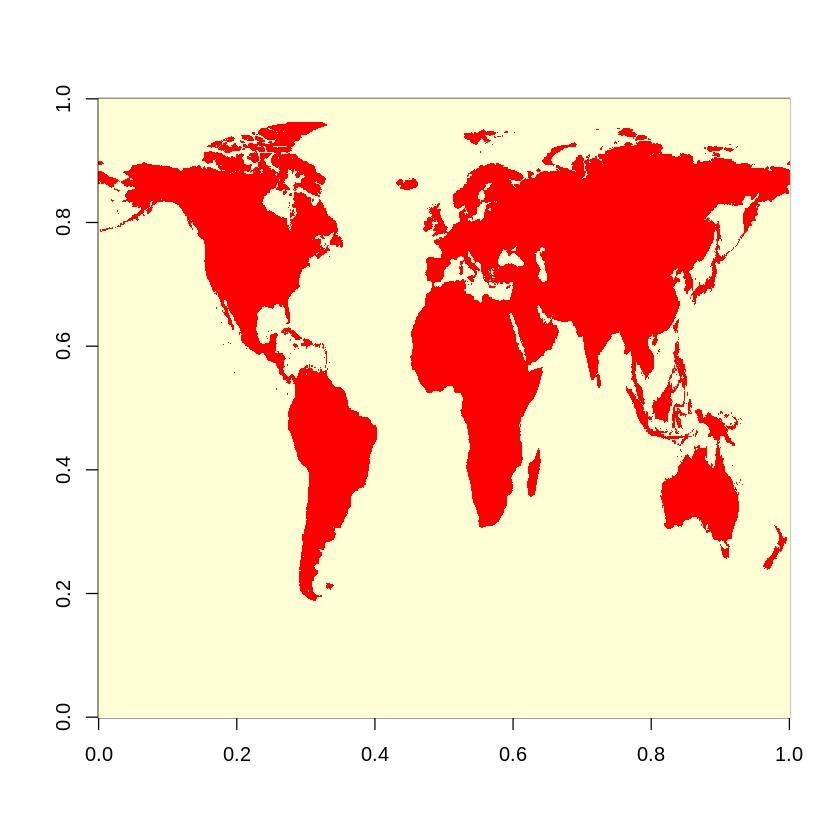

In [6]:
system.time( {
    sea <- apply(runoff, c(1,2), function(x) all(is.na(x)))
})
image(sea)

Compute drought indices for runoff. 

In [12]:
system.time(compute_index(runoff, 3, 0.25, "sri3_monthly_025.nc", 15)) # ~ 5minutes with 15 cores
system.time(compute_index(runoff, 12, 0.25, "sri12_monthly_025.nc", 15))

[1] "calculating index.."
[1] "creating array..."
[1] "writing netcdf..."


    user   system  elapsed 
4040.944   84.432  289.457 

[1] "calculating index.."
[1] "creating array..."
[1] "writing netcdf..."


    user   system  elapsed 
4135.568  140.868  307.445 

In [13]:
# read in array
nc <- nc_open(paste0(base_url, "discharge_global_monthly.nc"))
runoff <- ncvar_get(nc, attributes(nc$var)$names[1])
nc_close(nc)

compute_index(runoff, 3, 0.25, "ssi3_monthly_0.25.nc", 15)
compute_index(runoff, 12, 0.25, "ssi12_monthly_0.25.nc", 15)

[1] "calculating index.."
[1] "creating array..."
[1] "writing netcdf..."
[1] "calculating index.."
[1] "creating array..."
[1] "writing netcdf..."
